In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

Let's pretend I am a professional data scientist at a conglomerate company that owns a ton of different restaurants in the (former) UK.

First I will load in the datasets, and then we will visualize the data and come up with an RFC.

In [2]:
# Load the dataset and drop a bunch of columns
data = pd.read_csv('..\\uk_restaurant_reviews.csv', nrows=1000).drop(
    ['uniq_id', 'url', 'category', 'title', 'review_text', 'author', 'author_url', 'food', 'value', 'service', 'visited_on'], axis=1)

# Clean the rating column. Almost all of the ratings are in the format '4 bubbles out of 5'
data.rating = data['rating'].apply(lambda x: float(str(x)[0]) if str(x)[0].isdigit() else np.nan)

# Convert the review_date column to datetime. Valid datetimes are 10 strings long.
data.review_date = pd.to_datetime(data.review_date.apply(lambda x: x if len(str(x))==10 else np.nan), yearfirst=True)

# Organize by date, reset index
data.sort_values('review_date', inplace=True)
data = data.set_index('review_date')

data.head()

,restaurant_id,restaurant_location,name,location,rating
review_date,,,,,
2010-06-07,g186338-d1022444,London,Pizza Express,"Harlow, United Kingdom",4.0
2011-09-07,g186338-d2164836,London,Cote,Ski,3.0
2011-10-29,g186338-d1022444,London,Pizza Express,"Norwich, United Kingdom",3.0
2011-11-11,g186338-d814817,London,The Cornwall Project at The Newman Arms,"Akron, Ohio",5.0
2012-01-28,g186338-d2443332,London,Ladudu,"London, United Kingdom",3.0


# The Problem
A very popular travel/review site shows that the restaurants that your company owns aren't doing well. However, I have reason to believe this is because there aren't very many reviews, and only people that have had bad experiences have felt the need to leave a review. I don't know if that is the actual case, but we will pretend that this is true.

Since our data ranges from 2010 all the way to 2017, it might be hard to detect a change in the average rating over so much data. Instead, let's look at a sliding window average. We will take the average rating over the last 90 days and graph that point. We will drop the oldest 7 days worth of data and add the next newest week to the calculation. 

# The Potential Solution
The boss of your restaurant conglomerate wants to boost your average restaurant rating by encouraging more people to leave reviews. I propose giving customers a 10% discount when they show proof of a review for their current visit. I believe that since people are getting a discount, they will leave more favorable reviews.

Years between first and last review: 6.81


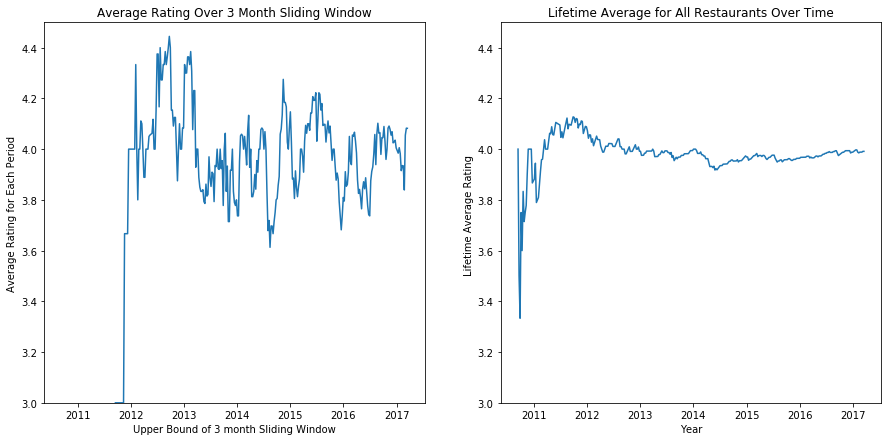

In [3]:
# Create an absolute measure of time, and floor divide by (86400*10**9) to convert to integer days.
data['time_index'] = data.index.astype(np.int64) // (86400*10**9)

# Initalize some variables for our rolling window loop
window_size = 91 # this is in days, equal to 13 weeks
rolling_average = np.zeros([(data.time_index.iloc[-1] - data.time_index.iloc[0] - window_size) // 7, 2])

# Sanity check: the length of rolling_average should be equal to the number of days between the first review
# date and the last review date. Divide by 52 weeks to get years between 2010-06-07 and 2017-03-22
print('Years between first and last review: {0:.2f}'.format((len(rolling_average) + window_size // 7) / 52))

for i, day in enumerate(rolling_average):
    rolling_average[i] = (data.rating[
        (data['time_index'] >= data.time_index.iloc[0] + i*7) &
        (data['time_index'] <= data.time_index.iloc[0] + i*7 + window_size)
    ].mean(),
    data.rating.iloc[0:i].mean())

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(pd.date_range('2010-09-09', '2017-03-22', freq='7D'), rolling_average[:,0])
plt.xlabel('Upper Bound of 3 month Sliding Window')
plt.ylabel('Average Rating for Each Period')
plt.ylim([3.0, 4.5])
plt.title('Average Rating Over 3 Month Sliding Window')

plt.subplot(1, 2, 2)
plt.plot(pd.date_range('2010-09-09', '2017-03-22', freq='7D'), rolling_average[:,1])
plt.ylabel('Lifetime Average Rating ')
plt.xlabel('Year')
plt.title('Lifetime Average for All Restaurants Over Time')
plt.ylim([3.0, 4.5])
plt.show()

We can clearly see that we get much more resolution with a 3 month sliding window as compared to the overall lifetime average. I think that this sliding window metric will therefore make a better metric in determing whether or not our promotion is helping business or not.

# The Method
The boss wants to be careful in the inital stages of the experiment. We will first select 10% of our restaurants to be our experimental group. We will randomly select them and compare their distribution of reviews to our control group over the previous 3 months. A t-test should show that these distributions are very similar and have a high p-value. This will be our A/A baseline test. If our t-test shows our distributions are different, then we may need to disqualify brand new restaurants from our population and select our groups again.

Next, we will implement our discount in our experimental group restaurants. After three months of running the experiment, we will compare the new control group distribution to the new experimental group distribution. The hope is that they will differ significantly enough (p<=0.05) to say that yes, the discount has increased the mean rating of our experimental group.

If results are inconclusive, we will run our experiment for two more months and expand our sliding window to 5 months.

If results are conclusive and positive, then we will give the discount to all restaurants. Our marketing strategy will have been a success, we will all get raises, get free restaurant food forever, and live happily ever after.

##### THE END